# Knife Edge Analysis

This notebook was used to compare several scanning electron microscope (SEM) images to look for degradation in image quality during the activation of an inductor in the imaging region. This analysis was presented in the publication 'A Cryo-CMOS Platform for Scalable and In Situ Quantum Materials Characterization' by Luca Nessi, Bevin Huang, Jinchen Wang,  Cole Brabec, Bogdan Dryzhakov, Qian Song, Ondrej Dyck, Stephen Jesse, Ruonan Han, Riccardo Comin, Dirk Englund, Jawaher Almutlaq [link when published].

Notbook authored by Ondrej Dyck and Grok June 4, 2025

Images acquired by Bogdan Dryzhakov

Substrate design and fabrication by Jawaher Almutlaq

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from scipy import ndimage
import os
from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D


### Get Filenames

In [8]:
files = os.listdir()

names = [name for name in files if '30.00kV' in name]

for name in names:
    print(name)

30.00kV_0.63nA_coil_ 0mV_applied_1.tif
30.00kV_0.63nA_coil_730 mV_applied_3.tif
30.00kV_0.63nA_coil_2100 mV_applied_4.tif
30.00kV_0.63nA_coil_210 mV_applied_2.tif


### Functions for Use Later

In [6]:
def get_line_profile(image, start_point, end_point, width):
    """
    Extract a line profile from an image between two points with specified width.
    The profile is averaged across the width perpendicular to the line.
    
    Parameters:
    - image: 2D numpy array (grayscale image)
    - start_point: Tuple (x1, y1) for the start of the line
    - end_point: Tuple (x2, y2) for the end of the line
    - width: Width of the profile (perpendicular to the line, in pixels)
    
    Returns:
    - profile: 1D array of intensity values along the line
    - distances: 1D array of distances along the line (in pixels)
    """
    x1, y1 = start_point
    x2, y2 = end_point
    
    length = int(np.hypot(x2 - x1, y2 - y1))
    if length == 0:
        raise ValueError("Start and end points are the same.")
    
    x, y = np.linspace(x1, x2, length), np.linspace(y1, y2, length)
    profile = np.zeros(length)
    
    dx, dy = x2 - x1, y2 - y1
    norm = np.hypot(dx, dy)
    if norm == 0:
        raise ValueError("Cannot compute perpendicular direction.")
    perp_dx, perp_dy = -dy / norm, dx / norm
    
    half_width = width / 2
    num_samples = max(1, int(width))
    offsets = np.linspace(-half_width, half_width, num_samples) if width > 1 else [0]
    
    for offset in offsets:
        x_offset = x + offset * perp_dx
        y_offset = y + offset * perp_dy
        sampled_values = ndimage.map_coordinates(image, np.vstack((y_offset, x_offset)), order=1)
        profile += sampled_values / len(offsets)
    
    distances = np.linspace(0, np.hypot(x2 - x1, y2 - y1), length)
    return profile, distances

def rolling_average(profile, window_size=5):
    """
    Apply a rolling average to the profile to reduce noise.
    
    Parameters:
    - profile: 1D array of intensity values
    - window_size: Size of the moving average window (in pixels)
    
    Returns:
    - smoothed_profile: 1D array of smoothed intensity values
    """
    if window_size % 2 == 0:
        window_size += 1
    return np.convolve(profile, np.ones(window_size)/window_size, mode='same')

def knife_edge_resolution(profile, distances, bar_threshold, dark_threshold, window_size=5):
    """
    Calculate the average edge width (threshold-to-threshold transition) for knife-edge resolution.
    
    Parameters:
    - profile: 1D array of intensity values
    - distances: 1D array of distances along the profile (in pixels)
    - bar_threshold: Intensity threshold for metal bars (high intensity)
    - dark_threshold: Intensity threshold for dark regions (low intensity)
    - window_size: Size of the rolling average window (in pixels)
    
    Returns:
    - avg_edge_width: Average edge width in pixels
    - edge_positions: List of (edge_idx, width, idx_start, idx_end, is_rising) for plotting
    - smoothed_profile: Smoothed profile used for edge detection
    - edge_widths: List of all edge widths for scatterplot
    """
    smoothed_profile = rolling_average(profile, window_size)
    
    print(f"Smoothed profile stats: min={smoothed_profile.min():.2f}, max={smoothed_profile.max():.2f}, "
          f"mean={smoothed_profile.mean():.2f}")
    print(f"Thresholds: bar={bar_threshold}, dark={dark_threshold}")
    
    if bar_threshold <= dark_threshold:
        raise ValueError("bar_threshold must be greater than dark_threshold.")
    
    # Find all threshold crossings
    dark_crossings = []
    bar_crossings = []
    for i in range(1, len(smoothed_profile)):
        # Dark threshold crossings
        if (smoothed_profile[i-1] > dark_threshold and smoothed_profile[i] <= dark_threshold) or \
           (smoothed_profile[i-1] <= dark_threshold and smoothed_profile[i] > dark_threshold):
            dark_crossings.append(i)
        # Bar threshold crossings
        if (smoothed_profile[i-1] < bar_threshold and smoothed_profile[i] >= bar_threshold) or \
           (smoothed_profile[i-1] >= bar_threshold and smoothed_profile[i] < bar_threshold):
            bar_crossings.append(i)
    
    print(f"Found {len(dark_crossings)} dark threshold crossings: {dark_crossings}")
    print(f"Found {len(bar_crossings)} bar threshold crossings: {bar_crossings}")
    
    if not dark_crossings or not bar_crossings:
        print("No threshold crossings detected. Check thresholds or profile.")
        return 0, [], smoothed_profile, []
    
    # Validate crossing counts (should be equal for 8 edges)
    if len(dark_crossings) != len(bar_crossings):
        print("Invalid number of crossings. Expected equal dark and bar crossings.")
        return 0, [], smoothed_profile, []
    
    edge_widths = []
    edge_positions = []
    
    # Pair crossings for each edge
    for i in range(len(dark_crossings)):
        idx_start = min(dark_crossings[i], bar_crossings[i])
        idx_end = max(dark_crossings[i], bar_crossings[i])
        width_pixels = idx_end - idx_start
        # Determine if rising (dark to bar) or falling (bar to dark)
        is_rising = dark_crossings[i] < bar_crossings[i]
        edge_type = "Rising" if is_rising else "Falling"
        
        if width_pixels > 0:
            edge_widths.append(width_pixels)
            edge_positions.append((idx_end, width_pixels, idx_start, idx_end, is_rising))
            print(f"{edge_type} edge {i+1}: idx_start={idx_start}, idx_end={idx_end}, width={width_pixels}")
        else:
            print(f"{edge_type} edge {i+1}: Invalid width (idx_start={idx_start}, idx_end={idx_end})")
    
    if not edge_widths:
        print("No valid edge widths calculated. Check crossing pairing.")
        return 0, [], smoothed_profile, []
    
    avg_edge_width = np.mean(edge_widths)
    return avg_edge_width, edge_positions, smoothed_profile, edge_widths

def plot_images_with_profile_box(image_paths, start_point, end_point, width):
    """
    Plot four images with a rotated rectangle indicating the line profile location and width.
    
    Parameters:
    - image_paths: List of paths to TIFF images
    - start_point: Tuple (x1, y1) for the start of the line
    - end_point: Tuple (x2, y2) for the end of the line
    - width: Width of the profile (perpendicular to the line, in pixels)
    """
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.ravel()
    
    x1, y1 = start_point
    x2, y2 = end_point
    
    length = np.hypot(x2 - x1, y2 - y1)
    if length == 0:
        raise ValueError("Start and end points are the same.")
    
    angle_rad = np.arctan2(y2 - y1, x2 - x1)
    angle_deg = np.degrees(angle_rad)
    
    dx, dy = x2 - x1, y2 - y1
    norm = np.hypot(dx, dy)
    perp_dx, perp_dy = -dy / norm, dx / norm
    half_width = width / 2
    rect_x = x1 - half_width * perp_dx
    rect_y = y1 - half_width * perp_dy
    
    for idx, (image_path, ax) in enumerate(zip(image_paths, axes)):
        image = io.imread(image_path, as_gray=True)
        if image.ndim != 2:
            raise ValueError(f"Image {image_path} is not grayscale.")
        
        ax.imshow(image, cmap='gray')
        ax.set_title(f'Image {idx + 1}')
        ax.axis('off')
        
        rect = Rectangle(
            (rect_x, rect_y), length, width, angle=angle_deg,
            edgecolor='red', facecolor='none', linewidth=2, linestyle='--'
        )
        ax.add_patch(rect)
        ax.plot([x1, x2], [y1, y2], 'ro', markersize=5)
    
    plt.tight_layout()
    #plt.show()

def plot_individual_profile(distances, smoothed_profile, edge_positions, bar_threshold, dark_threshold, image_idx):
    """
    Plot a single profile with edge regions highlighted.
    
    Parameters:
    - distances: 1D array of distances along the profile
    - smoothed_profile: 1D array of smoothed intensity values
    - edge_positions: List of (edge_idx, width, idx_start, idx_end, is_rising)
    - bar_threshold: Intensity threshold for bars
    - dark_threshold: Intensity threshold for dark regions
    - image_idx: Index of the image (1-based)
    """
    plt.figure(figsize=(10, 6))
    plt.plot(distances, smoothed_profile, color='tab:orange', label='Smoothed Profile', linewidth=2)
    plt.axhline(bar_threshold, color='r', linestyle='-', alpha=0.7, label='Bar Threshold')
    plt.axhline(dark_threshold, color='b', linestyle='-', alpha=0.7, label='Dark Threshold')
    
    for edge_idx, width, idx_start, idx_end, is_rising in edge_positions:
        label = 'Edge'
        plt.axvspan(distances[idx_start], distances[idx_end], color='gray', alpha=0.3,
                    label=label if edge_idx == edge_positions[0][0] else None)
    
    plt.title(f'Profile for Image {image_idx}')
    plt.xlabel('Distance along line (pixels)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

def plot_edge_width_scatter(edge_widths_list, image_names):
    """
    Create a scatterplot of edge widths per profile with mean and std dev.
    
    Parameters:
    - edge_widths_list: List of lists of edge widths for each profile
    - image_names: List of image filenames for labels
    """
    plt.figure(figsize=(8, 6))
    x_labels = [os.path.basename(name) for name in image_names]
    x = np.arange(len(x_labels))
    
    for i, edge_widths in enumerate(edge_widths_list):
        if edge_widths:
            plt.scatter([i] * len(edge_widths), edge_widths, color='blue', alpha=0.6, label='Edge Widths' if i == 0 else None)
            mean_width = np.mean(edge_widths)
            std_width = np.std(edge_widths)
            plt.plot([i-0.2, i+0.2], [mean_width, mean_width], 'k--', label='Mean' if i == 0 else None)
            plt.fill_between([i-0.2, i+0.2], [mean_width-std_width, mean_width-std_width],
                            [mean_width+std_width, mean_width+std_width], color='gray', alpha=0.2,
                            label='±1 Std Dev' if i == 0 else None)
    
    plt.xticks(x, x_labels, rotation=45, ha='right')
    plt.ylabel('Edge Width (pixels)')
    plt.title('Edge Widths per Profile')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

def plot_debug_profile(profile, smoothed_profile, distances, bar_threshold, dark_threshold):
    """
    Plot raw and smoothed profiles for debugging.
    
    Parameters:
    - profile: Raw profile intensities
    - smoothed_profile: Smoothed profile intensities
    - distances: Distances along the profile
    - bar_threshold: Intensity threshold for bars
    - dark_threshold: Intensity threshold for dark regions
    """
    plt.figure(figsize=(10, 6))
    plt.plot(distances, profile, label='Raw Profile', alpha=0.5)
    plt.plot(distances, smoothed_profile, label='Smoothed Profile', linewidth=2)
    plt.axhline(bar_threshold, color='r', linestyle='-', alpha=0.7, label='Bar Threshold')
    plt.axhline(dark_threshold, color='b', linestyle='-', alpha=0.7, label='Dark Threshold')
    plt.title('Debug Profile (First Image)')
    plt.xlabel('Distance along line (pixels)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.show()

### Get Line Profiles

The images show the inductor coil which provides us with sharp edges that transition from bright (on the metal coil) to dark (spaces between the coil). This feature will allow us to examine the sharpness of the transition and compare across the voltages used.

Displaying images with line profile location. Adjust start_point, end_point, and width as needed.


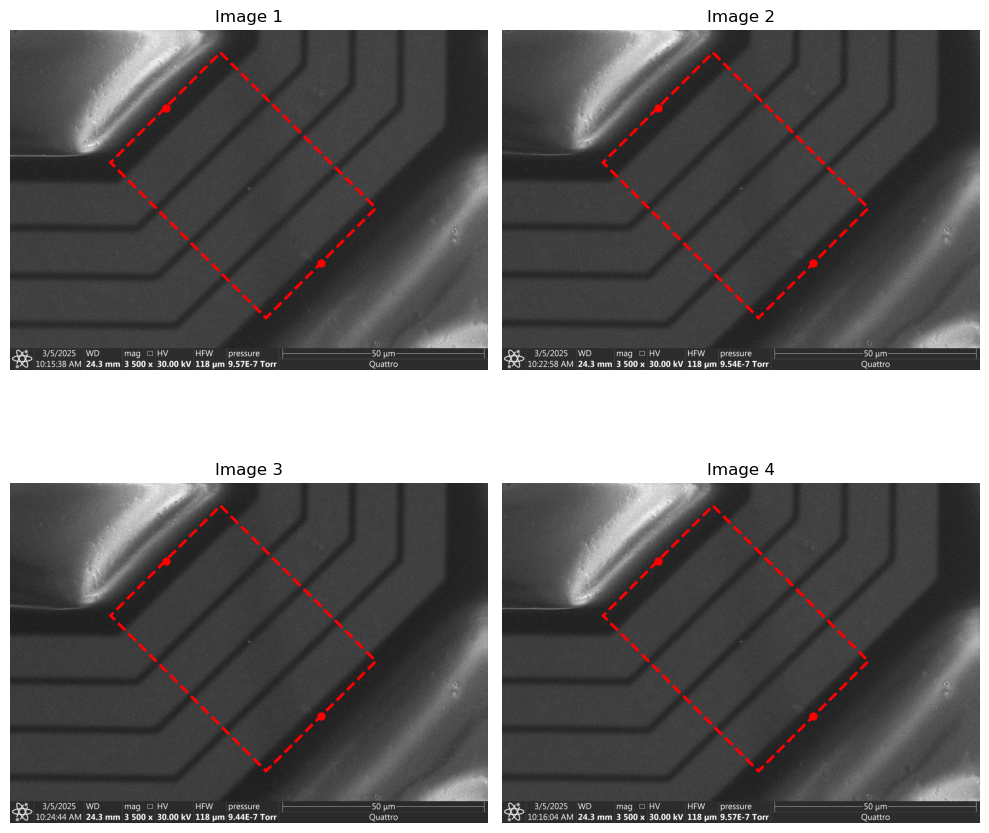

Plotting debug profile for first image...


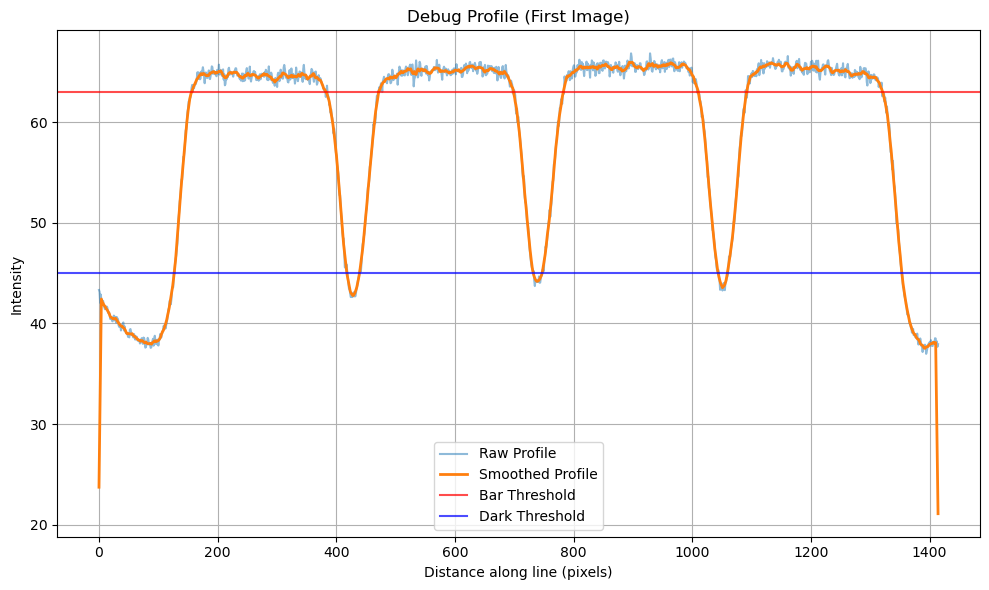

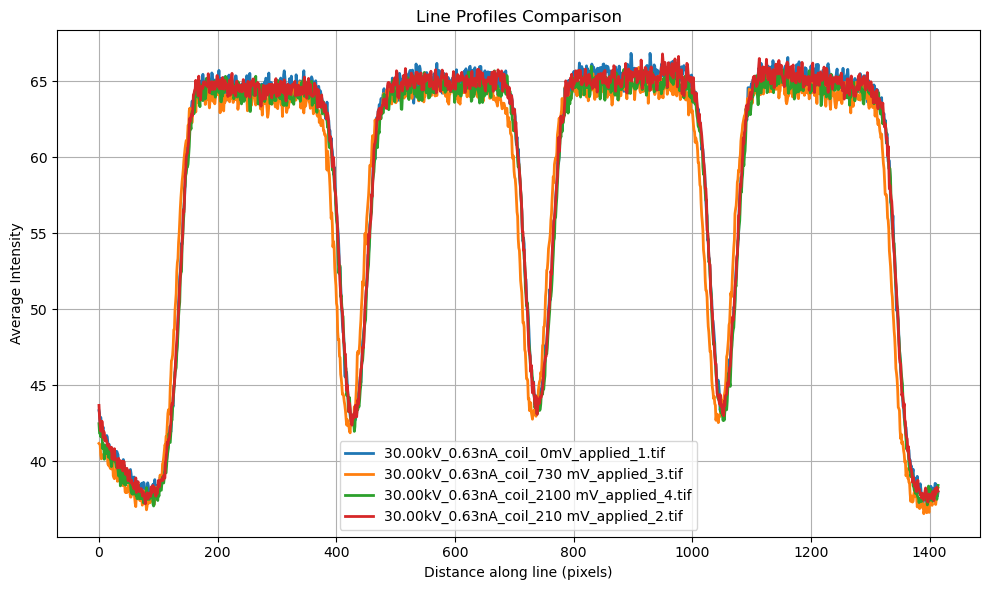

In [9]:
# Parameters for the line profile
start_point = (1000, 500)  # (x1, y1)
end_point = (2000, 1500)  # (x2, y2)
width = 1000  # Width in pixels for noise reduction
bar_threshold = 63  # Intensity for metal bars (e.g., 0-255 for 8-bit)
dark_threshold = 45  # Intensity for dark regions
window_size = 8  # Rolling average window size (pixels)

# Validate image paths
for path in names:
    if not os.path.exists(path):
        raise FileNotFoundError(f"Image file {path} not found.")

# Plot images with profile box
print("Displaying images with line profile location. Adjust start_point, end_point, and width as needed.")
plot_images_with_profile_box(names, start_point, end_point, width)
#plt.savefig('profile_location.svg', bbox_inches='tight')
plt.show()

# Debug profile for first image
print("Plotting debug profile for first image...")
image = io.imread(names[0], as_gray=True)
profile, distances = get_line_profile(image, start_point, end_point, width)
smoothed_profile = rolling_average(profile, window_size)
plot_debug_profile(profile, smoothed_profile, distances, bar_threshold, dark_threshold)
#plt.savefig('first_profile.svg', bbox_inches='tight')
plt.show()

# Initialize plot for combined profiles
plt.figure(figsize=(10, 6))

# Process each image
for idx, image_path in enumerate(names):
    image = io.imread(image_path, as_gray=True)
    if image.ndim != 2:
        raise ValueError(f"Image {image_path} is not grayscale.")
    
    profile, distances = get_line_profile(image, start_point, end_point, width)
    plt.plot(distances, profile, label=f'{os.path.basename(image_path)}', linewidth=2)

# Customize plot
plt.title('Line Profiles Comparison')
plt.xlabel('Distance along line (pixels)')
plt.ylabel('Average Intensity')
plt.legend()
plt.grid(True)
plt.tight_layout()
#plt.savefig('all_profiles.svg', bbox_inches='tight')
plt.show()


Note here that the image order (e.g. 'Image 1', 'Image 2' etc.) is arbitrary, based on the order in which each image appears in the file system. We will worry about which image corresponds to a specific applied voltage in the final comparison but for now we want to simply nail down the logic of finding the edges and their sharpness.

### Define Edges

We will use the same thresholds for each image.

Generating line profiles and calculating knife-edge resolution...

Processing 30.00kV_0.63nA_coil_ 0mV_applied_1.tif:
Smoothed profile stats: min=21.12, max=65.94, mean=58.81
Thresholds: bar=63, dark=45
Found 8 dark threshold crossings: [127, 418, 439, 732, 747, 1043, 1059, 1353]
Found 8 bar threshold crossings: [157, 383, 472, 699, 782, 1010, 1091, 1320]
Rising edge 1: idx_start=127, idx_end=157, width=30
Falling edge 2: idx_start=383, idx_end=418, width=35
Rising edge 3: idx_start=439, idx_end=472, width=33
Falling edge 4: idx_start=699, idx_end=732, width=33
Rising edge 5: idx_start=747, idx_end=782, width=35
Falling edge 6: idx_start=1010, idx_end=1043, width=33
Rising edge 7: idx_start=1059, idx_end=1091, width=32
Falling edge 8: idx_start=1320, idx_end=1353, width=33


<Figure size 1000x600 with 0 Axes>

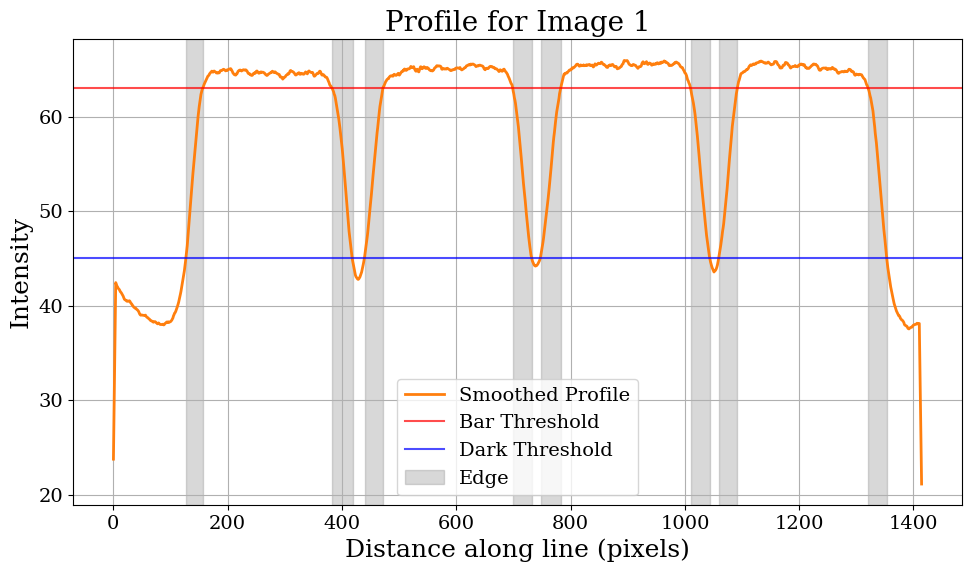


Processing 30.00kV_0.63nA_coil_730 mV_applied_3.tif:
Smoothed profile stats: min=20.97, max=65.11, mean=57.97
Thresholds: bar=63, dark=45
Found 8 dark threshold crossings: [121, 410, 434, 722, 742, 1034, 1054, 1345]
Found 8 bar threshold crossings: [157, 367, 474, 686, 780, 999, 1090, 1309]
Rising edge 1: idx_start=121, idx_end=157, width=36
Falling edge 2: idx_start=367, idx_end=410, width=43
Rising edge 3: idx_start=434, idx_end=474, width=40
Falling edge 4: idx_start=686, idx_end=722, width=36
Rising edge 5: idx_start=742, idx_end=780, width=38
Falling edge 6: idx_start=999, idx_end=1034, width=35
Rising edge 7: idx_start=1054, idx_end=1090, width=36
Falling edge 8: idx_start=1309, idx_end=1345, width=36


<Figure size 1000x600 with 0 Axes>

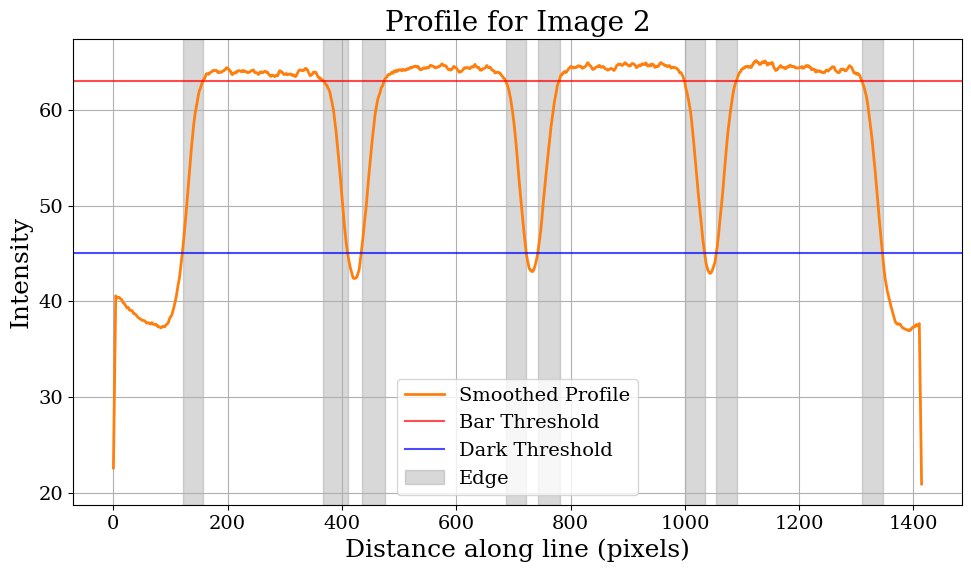


Processing 30.00kV_0.63nA_coil_2100 mV_applied_4.tif:
Smoothed profile stats: min=21.07, max=65.44, mean=58.28
Thresholds: bar=63, dark=45
Found 8 dark threshold crossings: [128, 418, 441, 731, 749, 1042, 1061, 1353]
Found 8 bar threshold crossings: [159, 380, 477, 696, 785, 1007, 1095, 1318]
Rising edge 1: idx_start=128, idx_end=159, width=31
Falling edge 2: idx_start=380, idx_end=418, width=38
Rising edge 3: idx_start=441, idx_end=477, width=36
Falling edge 4: idx_start=696, idx_end=731, width=35
Rising edge 5: idx_start=749, idx_end=785, width=36
Falling edge 6: idx_start=1007, idx_end=1042, width=35
Rising edge 7: idx_start=1061, idx_end=1095, width=34
Falling edge 8: idx_start=1318, idx_end=1353, width=35


<Figure size 1000x600 with 0 Axes>

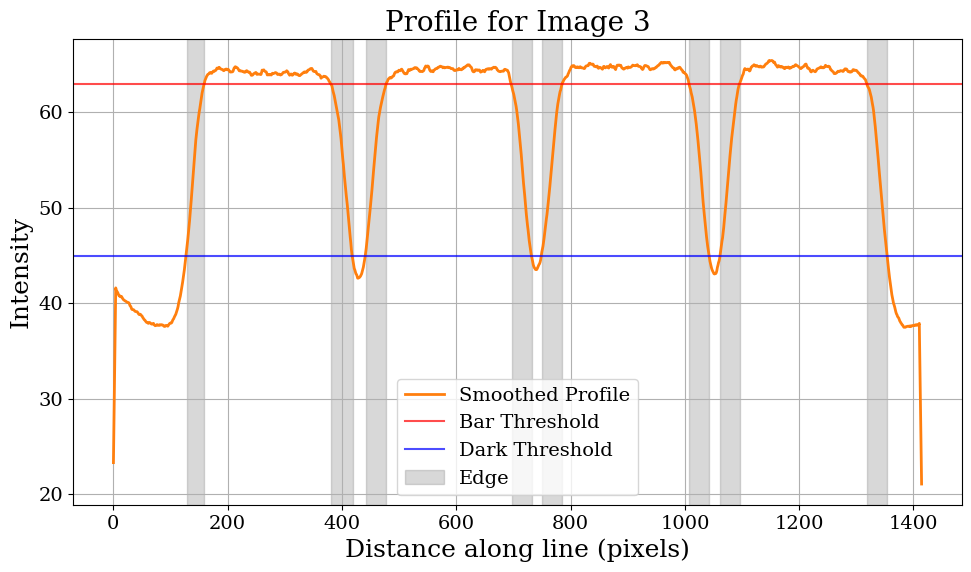


Processing 30.00kV_0.63nA_coil_210 mV_applied_2.tif:
Smoothed profile stats: min=21.16, max=65.96, mean=58.70
Thresholds: bar=63, dark=45
Found 8 dark threshold crossings: [127, 419, 439, 731, 747, 1042, 1059, 1353]
Found 8 bar threshold crossings: [157, 382, 474, 699, 782, 1010, 1092, 1320]
Rising edge 1: idx_start=127, idx_end=157, width=30
Falling edge 2: idx_start=382, idx_end=419, width=37
Rising edge 3: idx_start=439, idx_end=474, width=35
Falling edge 4: idx_start=699, idx_end=731, width=32
Rising edge 5: idx_start=747, idx_end=782, width=35
Falling edge 6: idx_start=1010, idx_end=1042, width=32
Rising edge 7: idx_start=1059, idx_end=1092, width=33
Falling edge 8: idx_start=1320, idx_end=1353, width=33


<Figure size 1000x600 with 0 Axes>

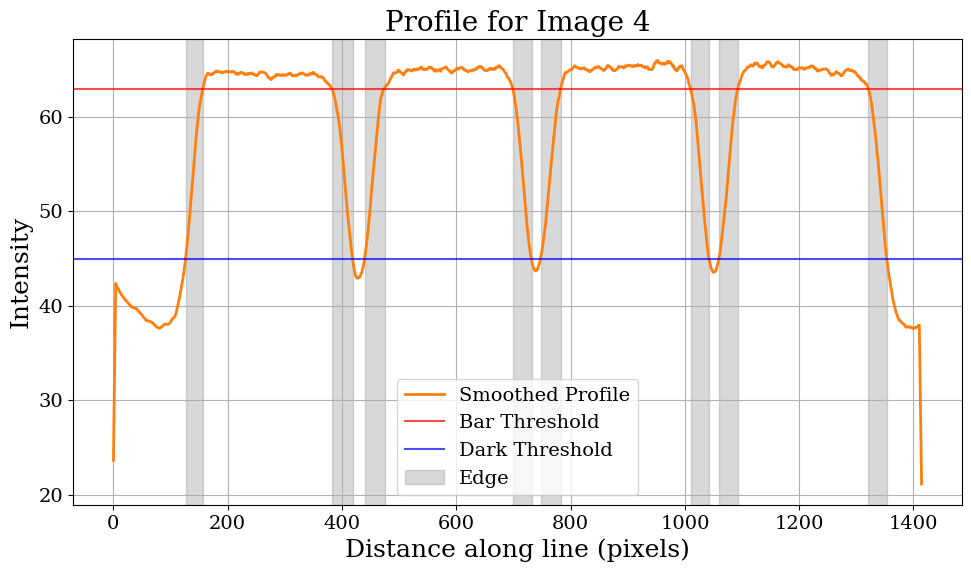


Knife-Edge Resolution Results:
30.00kV_0.63nA_coil_ 0mV_applied_1.tif: Mean Edge Width = 33.00 pixels, Std Dev = 1.50 pixels
30.00kV_0.63nA_coil_730 mV_applied_3.tif: Mean Edge Width = 37.50 pixels, Std Dev = 2.55 pixels
30.00kV_0.63nA_coil_2100 mV_applied_4.tif: Mean Edge Width = 35.00 pixels, Std Dev = 1.87 pixels
30.00kV_0.63nA_coil_210 mV_applied_2.tif: Mean Edge Width = 33.38 pixels, Std Dev = 2.06 pixels


<Figure size 800x600 with 0 Axes>

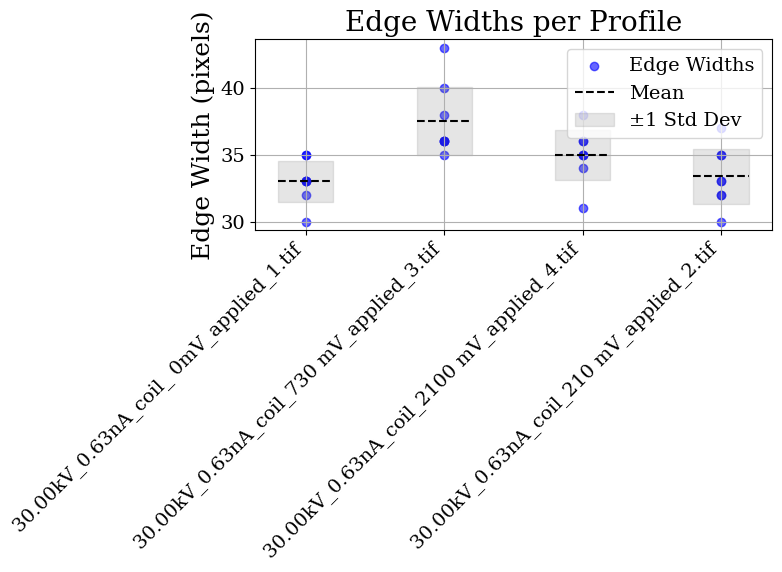

In [13]:
# Proceed to extract profiles and perform knife-edge resolution analysis
print("Generating line profiles and calculating knife-edge resolution...")
edge_widths_all = []
results_all = []  # Initialize results_all

for idx, image_path in enumerate(names):
    image = io.imread(image_path, as_gray=True)
    profile, distances = get_line_profile(image, start_point, end_point, width)
    
    print(f"\nProcessing {os.path.basename(image_path)}:")
    avg_edge_width, edge_positions, smoothed_profile, edge_widths = knife_edge_resolution(
        profile, distances, bar_threshold, dark_threshold, window_size
    )
    edge_widths_all.append(edge_widths)
    
    # Compute threshold crossings for storage
    dark_crossings = []
    bar_crossings = []
    for i in range(1, len(smoothed_profile)):
        if (smoothed_profile[i-1] > dark_threshold and smoothed_profile[i] <= dark_threshold) or \
           (smoothed_profile[i-1] <= dark_threshold and smoothed_profile[i] > dark_threshold):
            dark_crossings.append(i)
        if (smoothed_profile[i-1] < bar_threshold and smoothed_profile[i] >= bar_threshold) or \
           (smoothed_profile[i-1] >= bar_threshold and smoothed_profile[i] < bar_threshold):
            bar_crossings.append(i)
    
    # Store results for this image
    results_all.append({
        'image_path': image_path,
        'edge_positions': edge_positions,
        'smoothed_profile': smoothed_profile,
        'distances': distances,
        'dark_crossings': dark_crossings,
        'bar_crossings': bar_crossings
    })
    
    # Plot individual profile
    plt.figure(figsize=(10, 6))  # Create new figure
    plot_individual_profile(distances, smoothed_profile, edge_positions, bar_threshold, dark_threshold, idx + 1)
    #plt.savefig(f'threshold_edge_image{idx+1}.svg', bbox_inches='tight', format='svg')
    plt.show()

# Print edge width statistics
print("\nKnife-Edge Resolution Results:")
for idx, edge_widths in enumerate(edge_widths_all):
    if edge_widths:
        mean_width = np.mean(edge_widths)
        std_width = np.std(edge_widths)
        print(f"{os.path.basename(names[idx])}: Mean Edge Width = {mean_width:.2f} pixels, Std Dev = {std_width:.2f} pixels")
    else:
        print(f"{os.path.basename(names[idx])}: No edges detected")

# Plot scatterplot of edge widths
plt.figure(figsize=(8, 6))  # Create new figure
plot_edge_width_scatter(edge_widths_all, names)
#plt.savefig('edge_widths_threshold.svg', bbox_inches='tight', format='svg')
plt.show()

The edges calculated in this way are conceptually a rough approximation. They do not account for any variation in intensity or the overall shape of the edge. They are calculated strictly based on the user defined thresholds. A better strategy is to use a sigmoid function and fit it to the edges so that we can extract the edge sharpness parameter for comparison.

However, to fit a sigmoid function we are going to use the information gained from the previous steps to give us good initial positions, parameter guesses, and fit regions for each sigmoid. In other words, the rough approximation is the first step toward a refined approach which we will examine next.

### Sigmoid Analysis

The sigmoid function is a function of the form:

$$ f(x) = \frac{L}{1 + e^{-k(x-x_0)}} + A$$

The parameter $L$ is a scaling parameter, $A$ is a constant offest, $x_0$ is the central position, and $k$ is the sharpness of the transition. 

Let's gain some intuition about how the sigmoid function works, and particularly the effect of the $k$ parameter, by plotting a few different values of $k$.

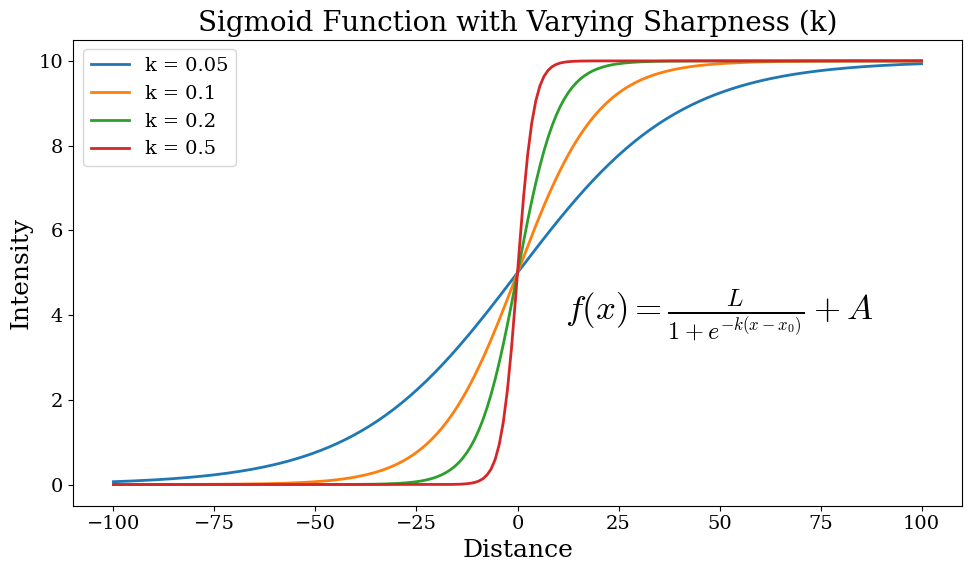

In [11]:

# Configure Matplotlib for serif fonts, including math text
plt.rc('font', family='serif')
plt.rc('mathtext', fontset='cm')  # Use Computer Modern serif for math text

# Increase font sizes globally
plt.rcParams.update({
    'font.size': 16,          # General font size
    'axes.titlesize': 20,     # Title
    'axes.labelsize': 18,     # Axis labels
    'legend.fontsize': 14,    # Legend
    'xtick.labelsize': 14,    # X-axis ticks
    'ytick.labelsize': 14     # Y-axis ticks
})

# Sigmoid function
def sigmoid(x, L, k, x0, A):
    """
    Sigmoid function: f(x) = L / (1 + e^(-k*(x - x0))) + A
    - L: Height of the curve
    - k: Steepness (positive for rising)
    - x0: Midpoint
    - A: Lower asymptote
    """
    return L / (1 + np.exp(-k * (x - x0))) + A

# Parameters for plotting
L = 10  # Height
x0 = 0  # Center at x=0 for simplicity
A = 0   # Lower asymptote
k_values = [0.05, 0.1, 0.2, 0.5]  # Steepness values for rising edges
x = np.linspace(-100, 100, 200)  # Range around x0

# Plot sigmoids
plt.figure(figsize=(10, 6))
for k in k_values:
    y = sigmoid(x, L, k, x0, A)
    plt.plot(x, y, label=f'k = {k}', linewidth=2)

# Add sigmoid equation in lower-middle-right
equation = r'$f(x) = \frac{L}{1 + e^{-k(x - x_0)}} + A$'
plt.text(0.90, 0.35, equation, fontsize=25, ha='right', va='bottom', 
         transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8, edgecolor='none'))

plt.title('Sigmoid Function with Varying Sharpness (k)')
plt.xlabel('Distance')
plt.ylabel('Intensity')
plt.legend()
plt.tight_layout()
#plt.savefig('sigmoid.svg', bbox_inches='tight')
plt.show()


We can see that the parameter $k$ is the one we are interested in for comparing the sharpness of the intensity transitions between the bright inductor coil and the darker surrounding material.

### Sigmoid Curve Fit

Now we will fit a sigmoid function to each of our edges.


Fitting sigmoids for 30.00kV_0.63nA_coil_ 0mV_applied_1.tif:
Edge 1 (Rising): L=24.20, k=0.13, x0=137.57, A=40.57
Edge 2 (Falling): L=25.06, k=-0.12, x0=406.74, A=39.49
Edge 3 (Rising): L=23.47, k=0.12, x0=453.49, A=41.53
Edge 4 (Falling): L=23.59, k=-0.12, x0=716.92, A=41.67
Edge 5 (Rising): L=22.46, k=0.12, x0=765.11, A=42.98
Edge 6 (Falling): L=24.00, k=-0.12, x0=1028.21, A=41.61
Edge 7 (Rising): L=22.31, k=0.13, x0=1076.51, A=43.25
Edge 8 (Falling): L=26.28, k=-0.11, x0=1342.88, A=38.72


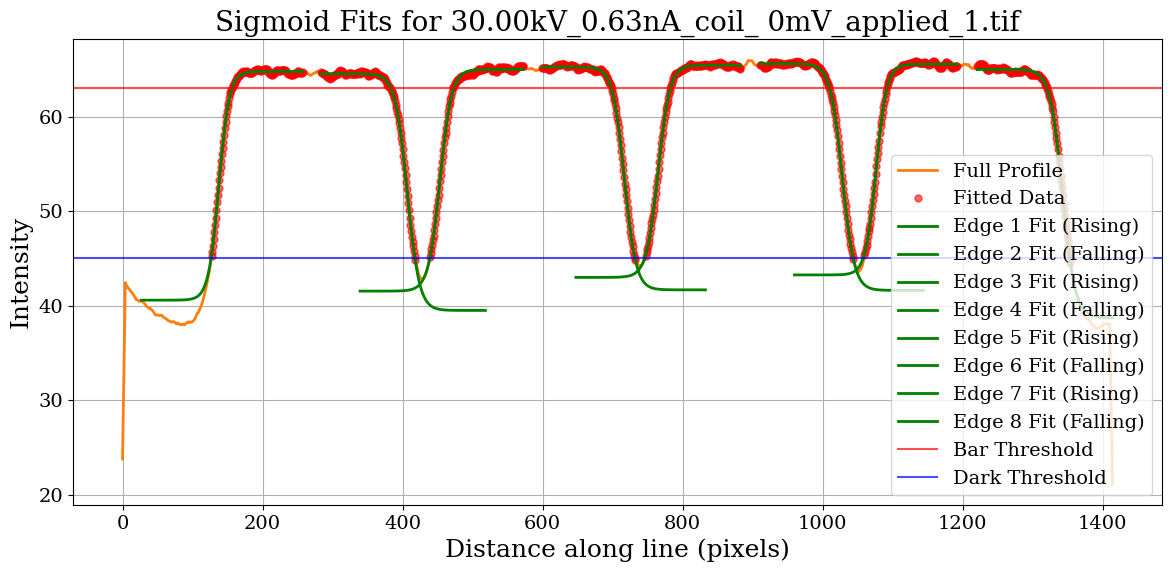


Fitting sigmoids for 30.00kV_0.63nA_coil_730 mV_applied_3.tif:
Edge 1 (Rising): L=24.24, k=0.12, x0=130.78, A=39.75
Edge 2 (Falling): L=23.89, k=-0.12, x0=398.57, A=39.87
Edge 3 (Rising): L=26.60, k=0.10, x0=443.62, A=37.73
Edge 4 (Falling): L=23.95, k=-0.12, x0=710.62, A=40.33
Edge 5 (Rising): L=23.44, k=0.11, x0=756.32, A=41.00
Edge 6 (Falling): L=23.68, k=-0.12, x0=1021.18, A=40.96
Edge 7 (Rising): L=23.50, k=0.12, x0=1068.21, A=41.13
Edge 8 (Falling): L=25.39, k=-0.11, x0=1335.81, A=38.82


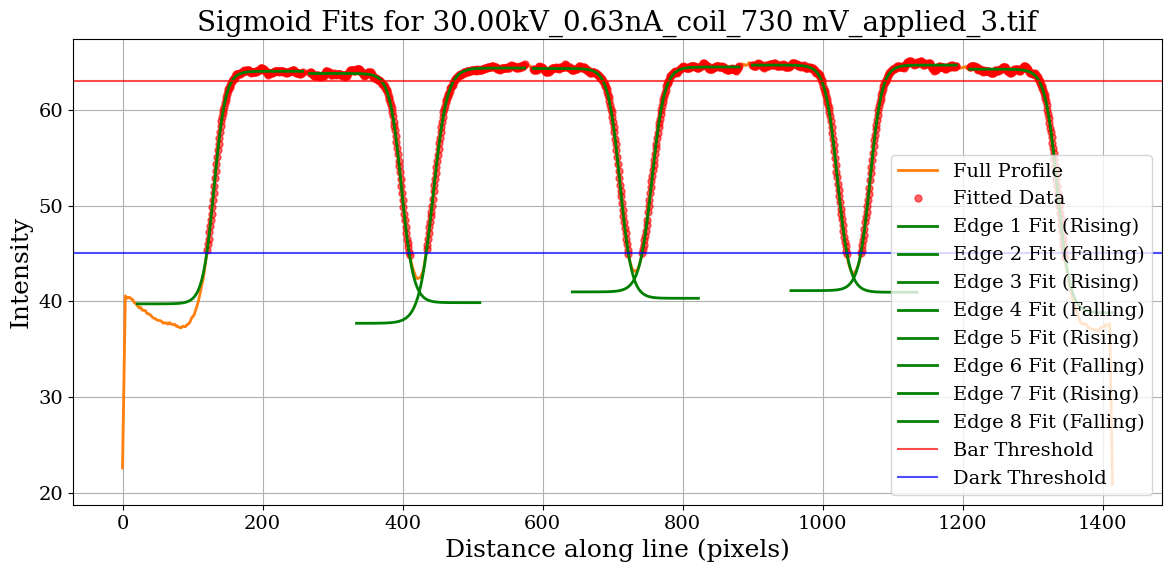


Fitting sigmoids for 30.00kV_0.63nA_coil_2100 mV_applied_4.tif:
Edge 1 (Rising): L=23.30, k=0.14, x0=138.58, A=41.06
Edge 2 (Falling): L=24.40, k=-0.11, x0=406.43, A=39.75
Edge 3 (Rising): L=25.40, k=0.11, x0=451.97, A=39.09
Edge 4 (Falling): L=22.33, k=-0.13, x0=716.61, A=42.24
Edge 5 (Rising): L=21.88, k=0.12, x0=765.94, A=42.92
Edge 6 (Falling): L=24.36, k=-0.12, x0=1029.17, A=40.51
Edge 7 (Rising): L=23.34, k=0.12, x0=1075.91, A=41.58
Edge 8 (Falling): L=24.37, k=-0.12, x0=1342.45, A=40.08


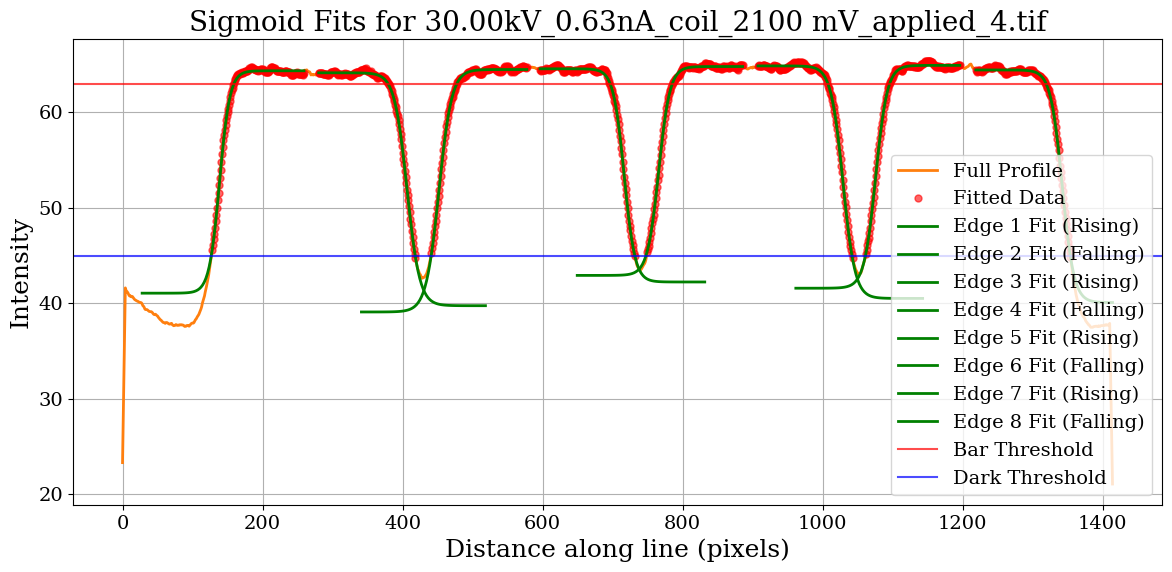


Fitting sigmoids for 30.00kV_0.63nA_coil_210 mV_applied_2.tif:
Edge 1 (Rising): L=22.36, k=0.14, x0=138.90, A=42.33
Edge 2 (Falling): L=24.26, k=-0.11, x0=406.13, A=40.19
Edge 3 (Rising): L=24.40, k=0.12, x0=452.53, A=40.53
Edge 4 (Falling): L=23.46, k=-0.13, x0=716.81, A=41.64
Edge 5 (Rising): L=22.29, k=0.13, x0=764.56, A=42.86
Edge 6 (Falling): L=24.62, k=-0.12, x0=1028.73, A=40.85
Edge 7 (Rising): L=23.00, k=0.13, x0=1075.70, A=42.48
Edge 8 (Falling): L=26.33, k=-0.11, x0=1343.16, A=38.50


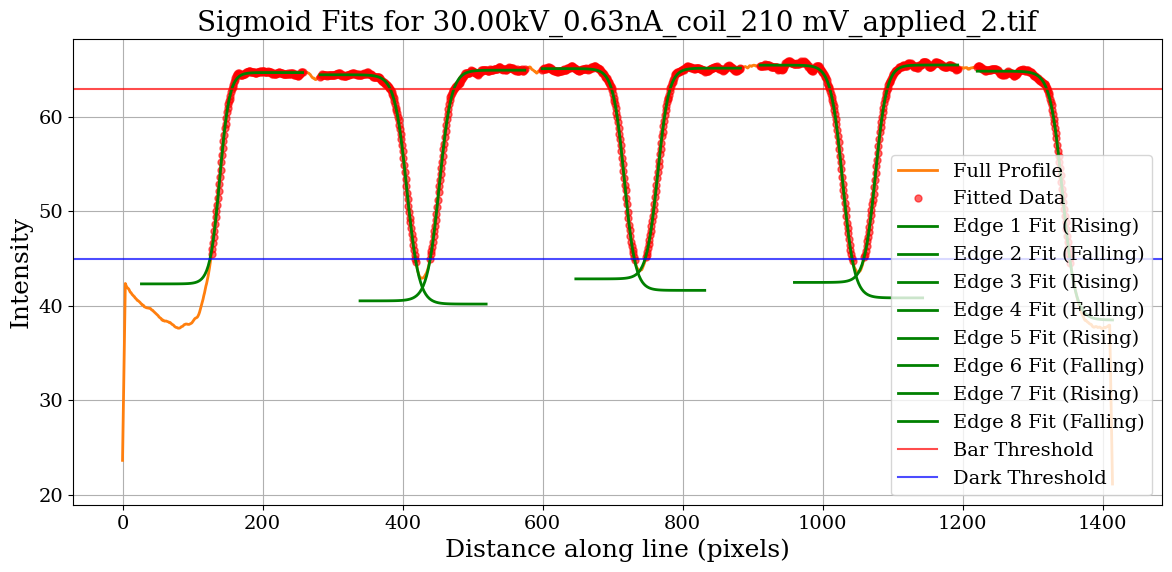

In [14]:
from scipy.optimize import curve_fit

# Sigmoid function for fitting
def sigmoid(x, L, k, x0, A):
    """
    Sigmoid function: f(x) = L / (1 + e^(-k*(x - x0))) + A
    - L: Height of the curve (intensity range)
    - k: Steepness (positive for rising, negative for falling)
    - x0: Midpoint of the transition
    - A: Lower asymptote
    """
    return L / (1 + np.exp(-k * (x - x0))) + A

# Parameters for sigmoid fitting
added_fit = 100  # Pixels to extend into bright region for fitting, also used for symmetric plot extension

# Fit sigmoid to each edge for each image
for idx, result in enumerate(results_all):
    image_path = result['image_path']
    edge_positions = result['edge_positions']
    smoothed_profile = result['smoothed_profile']
    distances = result['distances']
    dark_crossings = result['dark_crossings']
    bar_crossings = result['bar_crossings']
    
    k_values = []  # Store |k| values for this image
    
    print(f"\nFitting sigmoids for {os.path.basename(image_path)}:")
    
    plt.figure(figsize=(12, 6))
    
    # Plot full intensity profile
    plt.plot(distances, smoothed_profile, color='tab:orange', linestyle='-', label='Full Profile', alpha=1, linewidth=2)
    
    for i, (edge_idx, width, idx_start, idx_end, is_rising) in enumerate(edge_positions):
        # Define fitting window (asymmetric, bright region only)
        if is_rising:
            fit_start = dark_crossings[i]
            fit_end = bar_crossings[i] + added_fit
        else:
            fit_start = bar_crossings[i] - added_fit
            fit_end = dark_crossings[i]
        
        # Ensure indices are within bounds
        fit_start = max(0, fit_start)
        fit_end = min(len(smoothed_profile), fit_end + 1)
        
        if fit_end <= fit_start:
            print(f"Edge {i+1} ({'Rising' if is_rising else 'Falling'}): Invalid fitting window (start={fit_start}, end={fit_end})")
            continue
        
        # Extract data for fitting
        x_data = distances[fit_start:fit_end]
        y_data = smoothed_profile[fit_start:fit_end]
        
        if len(x_data) < 4:  # Need enough points for fitting
            print(f"Edge {i+1} ({'Rising' if is_rising else 'Falling'}): Insufficient data points ({len(x_data)})")
            continue
        
        # Plot fitted data points in a different color
        plt.plot(x_data, y_data, 'ro', label='Fitted Data' if i == 0 else None, alpha=0.6, markersize=5)
        
        # Initial guess for parameters: [L, k, x0, A]
        L_init = bar_threshold - dark_threshold
        k_init = 0.1 if is_rising else -0.1
        x0_init = (idx_start + idx_end) / 2
        A_init = dark_threshold
        p0 = [L_init, k_init, x0_init, A_init]
        
        try:
            # Fit sigmoid
            popt, _ = curve_fit(sigmoid, x_data, y_data, p0=p0, maxfev=1000)
            L, k, x0, A = popt
            
            # Store |k|
            k_values.append(abs(k))
            
            # Define symmetric plotting range for sigmoid
            plot_start = min(idx_start, idx_end) - added_fit
            plot_end = max(idx_start, idx_end) + added_fit
            plot_start = max(0, plot_start)
            plot_end = min(len(smoothed_profile), plot_end + 1)
            
            # Generate points for plotting the fit
            x_fit = np.linspace(distances[plot_start], distances[plot_end-1], 100)
            y_fit = sigmoid(x_fit, *popt)
            
            # Plot sigmoid fit
            plt.plot(x_fit, y_fit, 'g-', label=f"Edge {i+1} Fit ({'Rising' if is_rising else 'Falling'})", linewidth=2)
            
            # Print fitted parameters
            print(f"Edge {i+1} ({'Rising' if is_rising else 'Falling'}): L={L:.2f}, k={k:.2f}, x0={x0:.2f}, A={A:.2f}")
        
        except RuntimeError:
            print(f"Edge {i+1} ({'Rising' if is_rising else 'Falling'}): Sigmoid fitting failed")
    
    # Store k_values in results_all
    results_all[idx]['k_values'] = k_values
    
    plt.axhline(bar_threshold, color='r', linestyle='-', alpha=0.7, label='Bar Threshold')
    plt.axhline(dark_threshold, color='b', linestyle='-', alpha=0.7, label='Dark Threshold')
    plt.title(f"Sigmoid Fits for {os.path.basename(image_path)}")
    plt.xlabel('Distance along line (pixels)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    #plt.savefig(f'fit{idx+1}.svg', bbox_inches='tight')
    plt.show()
    

Here, the sigmoid curves are shown in green, the datapoints used for the fitting are shown in red, the original profile is shown in blue, and the thresholds used to find the edges are shown by the horizontal lines.

Next, we want to compare the $k$ values obtained by the fitting.

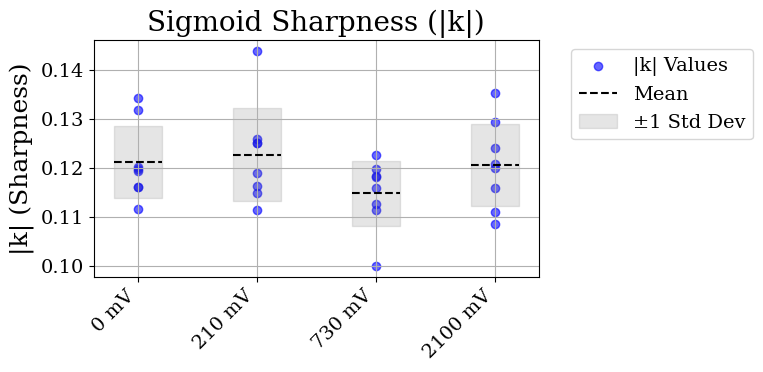

In [15]:

# Desired order and labels
new_labels = ['0 mV', '210 mV', '730 mV', '2100 mV']
order_indices = [0, 3, 1, 2]  # Map names to new order: 0 mV (0), 210 mV (3), 730 mV (1), 2100 mV (2)

# Plot |k| values
plt.figure(figsize=(8, 4))
x = np.arange(len(new_labels))

for i, idx in enumerate(order_indices):
    k_values = results_all[idx].get('k_values', [])
    if k_values:
        # Plot individual |k| points
        plt.scatter([i] * len(k_values), k_values, color='blue', alpha=0.6, label='|k| Values' if i == 0 else None)
        # Compute mean and std dev
        mean_k = np.mean(k_values)
        std_k = np.std(k_values)
        # Plot mean line
        plt.plot([i-0.2, i+0.2], [mean_k, mean_k], 'k--', label='Mean' if i == 0 else None)
        # Plot std dev shading
        plt.fill_between([i-0.2, i+0.2], [mean_k-std_k, mean_k-std_k],
                         [mean_k+std_k, mean_k+std_k], color='gray', alpha=0.2,
                         label='±1 Std Dev' if i == 0 else None)

plt.xticks(x, new_labels, rotation=45, ha='right')
plt.ylabel('|k| (Sharpness)')
plt.title('Sigmoid Sharpness (|k|)')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.grid(True)
plt.tight_layout()
#plt.savefig('sharpness_comparison.svg', bbox_inches='tight')
plt.show()


From this plot we can see that the activation of the inductor coil does not produce any decrease in resolution. The average difference in sharpness from one image to the next is not greater than the variability in the measurement technique itself. 